In [154]:
#calculateCpCtFromFAST
# script for computing the CP CT from FAST
# run fast using a step wind input file while outputting:
# HorWindV, RotSpeed, BlPitch1, GenTq, RotCp, GenCp, RotCt

#NOTE: This provides rotor Cp/Ct, not yet including efficiency losses

In [155]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import readFASTOutput
import pickle

In [156]:
## Parameters
fastFolder = 'stepSim'
fastOutputFile = 'NRELOffshrBsline5MW_Onshore.out'
windStep = 100. # how often to steps in wind occur
startTime = 0. #if there is some initial settling time

#Turbine Parameters
R = 63.0 #from FST file
rho = 1.225 #from AD ipt file
g = 9.81 # from FST file
tilt = 5.0 * np.pi/180.0 # from FST file
RotMass = 110000.234 # kg from FSM file

In [157]:
# Load the FAST output
FAST = readFASTOutput.readFASTOutput(os.path.join(fastFolder,fastOutputFile))

In [158]:
# Determine sampling points
simLength = FAST.time[-1]
DT = FAST.time[1] - FAST.time[0]

sampPointsTime = np.arange(startTime + windStep - 2 * DT ,simLength-2 * DT ,windStep) # Take samples 1 s before step
sampPointsIndex = sampPointsTime / DT - 1
sampPointsIndex = sampPointsIndex.astype('int')

print simLength, windStep
print sampPointsTime
print FAST.time[sampPointsIndex]

2100.0 100.0
[   98.   198.   298.   398.   498.   598.   698.   798.   898.   998.
  1098.  1198.  1298.  1398.  1498.  1598.  1698.  1798.  1898.  1998.]
[   98.   198.   298.   398.   498.   598.   698.   798.   898.   998.
  1098.  1198.  1298.  1398.  1498.  1598.  1698.  1798.  1898.  1998.]


In [159]:
#Show available channels (if needed un-comment)
#FAST.channels

(50, 2100.0)

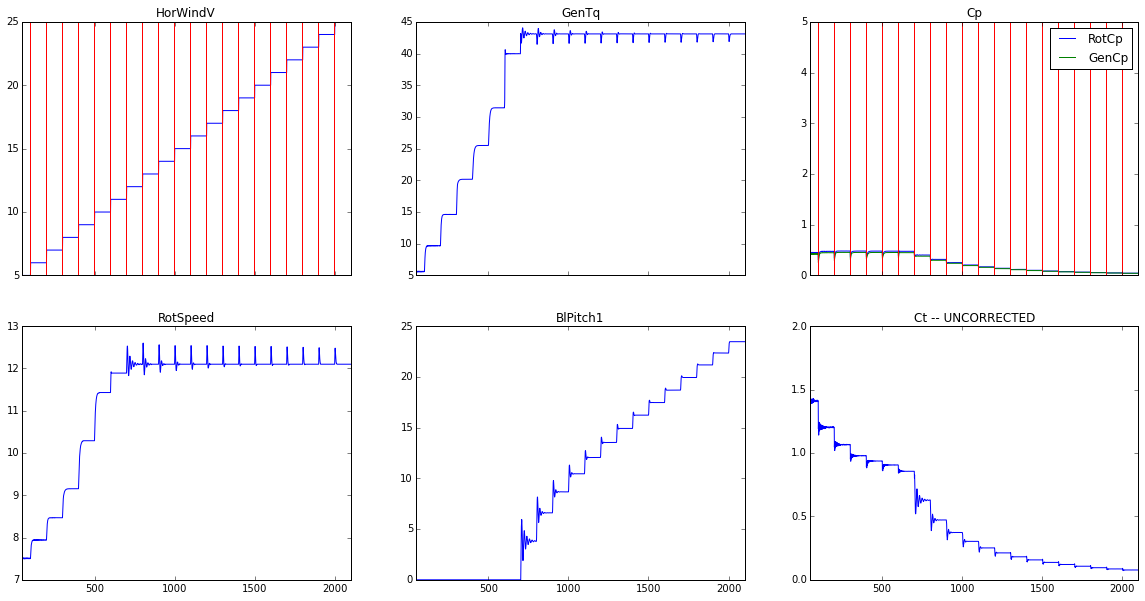

In [160]:
# Plot the basic signals, make sure things are pretty steeady towards the end of each step
fix, axarr = plt.subplots(2,3,sharex = True, figsize = (20,10))

ax = axarr[0,0]
chan = 'HorWindV'
ax.plot(FAST.time, FAST.data[chan])
ax.set_title(chan)
for samp in sampPointsTime:
    ax.axvline(samp,color='r')

ax = axarr[1,0]
chan = 'RotSpeed'
ax.plot(FAST.time, FAST.data[chan])
ax.set_title(chan)

ax = axarr[0,1]
chan = 'GenTq'
ax.plot(FAST.time, FAST.data[chan])
ax.set_title(chan)

ax = axarr[1,1]
chan = 'BlPitch1'
ax.plot(FAST.time, FAST.data[chan])
ax.set_title(chan)

ax = axarr[0,2]
chan = 'RotCp'
ax.plot(FAST.time, FAST.data[chan],label=chan)
chan = 'GenCp'
ax.plot(FAST.time, FAST.data[chan],label=chan)
ax.set_title('Cp')
ax.legend(loc='best')
for samp in sampPointsTime:
    ax.axvline(samp,color='r')

ax = axarr[1,2]
chan = 'RotCt'
ax.plot(FAST.time, FAST.data[chan],label=chan)
ax.set_title('Ct -- UNCORRECTED')
ax.set_xlim([50,simLength])

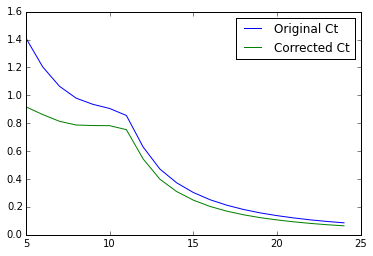

In [161]:
## Now correct Ct for gravity loads (necessary for FAST7)

#Make a new dataframe for convenience
data = pd.DataFrame({'Time':FAST.time,'Wind':FAST.data['HorWindV'],'RotCp':FAST.data['RotCp'],'RotCt':FAST.data['RotCt']}).loc[sampPointsIndex]

# Compute corrected CT coefficient and re-plot Ct
Ad = np.pi * R ** 2

data['T'] = 0.5  * rho * Ad * (data.Wind**2) * data.RotCt
data['T'] = data['T'] - RotMass  * g * np.sin(tilt)
data['RotCtCor'] = data['T'] / (0.5 * rho * Ad * data.Wind**2)

fix,ax = plt.subplots(1)
ax.plot(data.Wind,data.RotCt,label='Original Ct')
ax.plot(data.Wind,data.RotCtCor,label='Corrected Ct')
ax.legend()

In [162]:
# Build final table and output
dataFinal = data.drop(['RotCt','Time','T'],axis=1)
dataFinal = dataFinal.rename(columns={'RotCtCor': 'Ct', 'RotCp': 'Cp'})
dataFinal = dataFinal[['Wind','Cp','Ct']]
dataFinal.to_csv('cpctTable.csv',index=False)
print dataFinal

      Wind       Cp        Ct
97       5  0.45290  0.917415
197      6  0.47560  0.861927
297      7  0.48110  0.813681
397      8  0.48040  0.786984
497      9  0.47970  0.783267
597     10  0.47870  0.782354
697     11  0.47580  0.753626
797     12  0.40220  0.543982
897     13  0.31620  0.398832
997     14  0.25320  0.310070
1097    15  0.20590  0.248468
1197    16  0.16960  0.203196
1297    17  0.14140  0.169489
1397    18  0.11910  0.143392
1497    19  0.10130  0.122787
1597    20  0.08684  0.106513
1697    21  0.07505  0.092976
1797    22  0.06522  0.081457
1897    23  0.05713  0.072241
1997    24  0.05029  0.064410


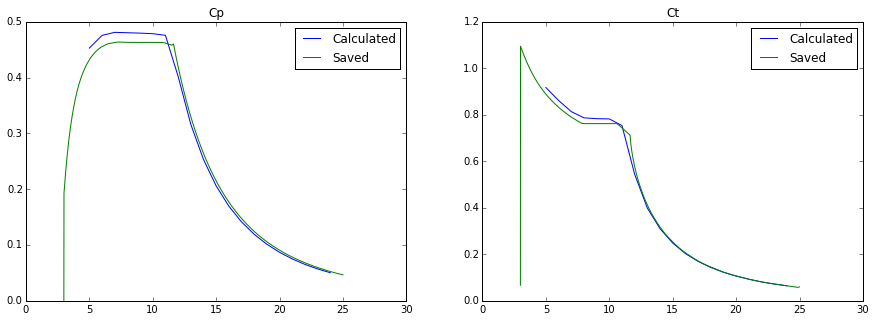

In [163]:
# Compare to saved version in FLORIS
dataSaved = pd.DataFrame(pickle.load( open( "saveFloris.p", "rb" ) ))

fig, axarr = plt.subplots(1,2,figsize=(15,5))

ax = axarr[0]
ax.plot(dataFinal.Wind,dataFinal.Cp,label='Calculated')
ax.plot(dataSaved.wind_speed,dataSaved.CP,label='Saved')
ax.set_title('Cp')
ax.legend()

ax = axarr[1]
ax.plot(dataFinal.Wind,dataFinal.Ct,label='Calculated')
ax.plot(dataSaved.wind_speed,dataSaved.CT,label='Saved')
ax.set_title('Ct')
ax.legend()